# Symulator tomografu komputerowego

**Data:** xx.03.2022

**Autorzy:**

Jakub Kwiatkowski 145356\
Paweł Strzelczyk 145217

## Abstrakt

`TODO`

#### Wykorzystane technologie

- [python](https://python.org) (v3.10)
- [jupyter notebooks](https://jupyter.org)


In [39]:
from ipywidgets import interact, interactive
from IPython.display import clear_output, display
import cv2 as cv
import ipywidgets
import numpy as np
import pydicom as dcm
import matplotlib.pylab as plt
import math
from skimage import io, draw
from ct_utils import bresenham, radon, normalize, inverse_radon, show

In [ ]:
# TODO: Transform image into sinogram (Radon transform)
img = plt.imread("data/test_1.jpg")
plt.imshow(img)
angles = np.linspace(0, np.pi, 180)
sinogram = radon(img, detector_count= 128, rotation_angles=angles)
print(sinogram)

In [ ]:
# TODO: Draw sinograph (sinogram visualization, every column in sinograph corresponds to row in sinogram)

sinogram


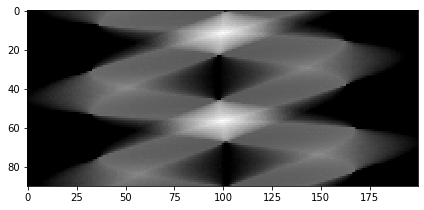

In [40]:
sinogram = cv.imread('data/sin_sample.png', cv.IMREAD_GRAYSCALE)
print('sinogram')
io.imshow(sinogram)
io.show()

In [45]:
detectors_slider = ipywidgets.IntSlider(180, 0, 200, 10)
display(detectors_slider)

def click():
    img = inverse_radon(sinogram, detectors=detectors_slider.value, img_size=128)
    io.imshow(img)
    io.show()



button = ipywidgets.Button(description="Run simulation")
display(button)

button.on_click(click)




IntSlider(value=180, max=200, step=10)

Button(description='Run simulation', style=ButtonStyle())